In [54]:
import cv2
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, gaussian
from skimage.feature import canny

# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt

from skimage.morphology import dilation, square
from skimage import morphology
from ipywidgets import interact, fixed, IntSlider, FloatSlider


In [55]:
from Functions.hough_transform_module import Hough
from Functions.preprocessing_functions import ROI, smooth, gray_to_binary, apply_errosion

If importing error occurs, uncomment the following cell and run it

In [56]:
#pip install ipywidgets

## Read video

In [57]:
# read the first frame of the video and store it
vidcap = cv2.VideoCapture('images/LaneVideo.mp4')
success, frame = vidcap.read()

In [4]:
# # Read and display frames
# while vidcap.isOpened():
#     ret, frame = vidcap.read()  # Read a frame
#     if ret:
#         cv2.imshow('Frame', frame)  # Display the frame
#         if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
#             break
#     else:
#         break

# # Release the capture when done
# cap.release()
# cv2.destroyAllWindows()


In [58]:
def plot_images(img1, img2, label1, label2):
    """Plots two images side by side."""
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the first image on the first subplot
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(label1)

    # Plot the second image on the second subplot
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(label2)

    # Show the plot
    plt.tight_layout()
    plt.show()

## Crop Image

In [59]:
# Crop image function 
cropped_img = None
x1, x2, y1, y2 = 0, 0, 0, 0

def ROI_test(img, x_start, x_end, y_start, y_end):
#   img = io.imread(path)
    global cropped_img, x1, x2, y1, y2
    x1, x2, y1, y2 = x_start, x_end, y_start, y_end
    cropped_img = img[y_start : y_end, x_start : x_end]
    plot_images(img, cropped_img, "Original Image", "Cropped Image")


In [60]:
H, W, _ = frame.shape

# Define sliders for the parameters
x_start_slider = IntSlider(min=0, max=W, step=5, value=200, description='x start:')
x_end_slider = IntSlider(min=0, max=W, step=5, value=1020, description='x end:')
y_start_slider = IntSlider(min=0, max=H, step=5, value=415, description='y start:')
y_end_slider = IntSlider(min=0, max=H, step=5, value=720, description='y end:')

# Create the interactive widget
interact(ROI_test, img=fixed(frame), 
         x_start=x_start_slider, y_start=y_start_slider,
         x_end=x_end_slider, y_end=y_end_slider)


interactive(children=(IntSlider(value=200, description='x start:', max=1280, step=5), IntSlider(value=1020, de…

<function __main__.ROI_test(img, x_start, x_end, y_start, y_end)>

In [7]:
cropped_img = ROI(image)

720 360


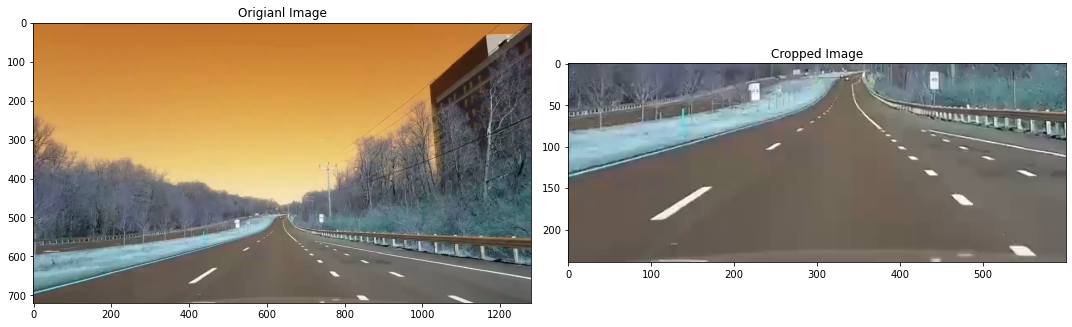

In [8]:
plot_images(image, cropped_img)

## Convert img to Gray & Smoothing

In [61]:
def smooth(image):
    """Applies median filter to smooth image."""
    gray_image = rgb2gray(image)
    f_image = median(gray_image)
    return f_image

In [62]:
smoothed_img = smooth(cropped_img)

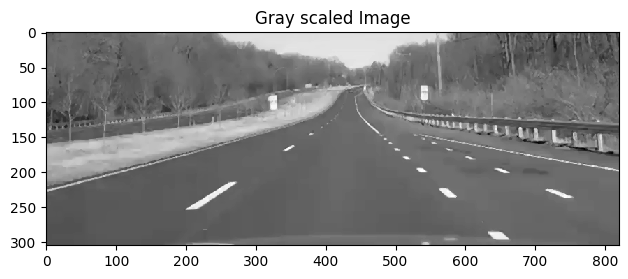

In [63]:
io.imshow(smoothed_img)
plt.title("Gray scaled Image")
plt.show()

## Prespective Transformation

In [64]:
def perspective_transformation(img):
    """Returns perspective transformation of an image."""
    H, W = img.shape
    
    # Define source points, points are defined as (col, row)
    d_top_left = (0, 0)
    d_top_right = (W-1, 0)
    d_bottom_left = (0, H - 1)
    d_bottom_right = (W - 1, H - 1)
    
    pts_destination = np.array([d_top_left, d_top_right, d_bottom_right, d_bottom_left], dtype=np.float32)
    
    # Define destination points
    s_top_left = (350, 140)
    s_top_right = (500, 140)
    s_bottom_left = (20, H - 30)
    s_bottom_right = (W -80, H - 40)
    pts_source = np.array([s_top_left, s_top_right, s_bottom_right, s_bottom_left], dtype=np.float32)
    
    # Get perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(pts_source, pts_destination)
    
    # Apply perspective transformation
    result = cv2.warpPerspective(img, matrix, (W, H))
    
    return result, matrix, pts_source


In [65]:
transformed_img, PT_matrix, pts_source = perspective_transformation(smoothed_img)

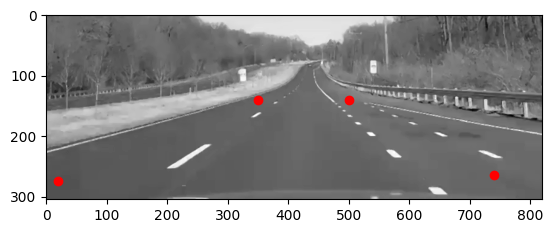

In [66]:
x, y = zip(*pts_source)
x, y = list(x), list(y)
plt.imshow(smoothed_img, cmap='gray')
plt.scatter(x, y, c='red')

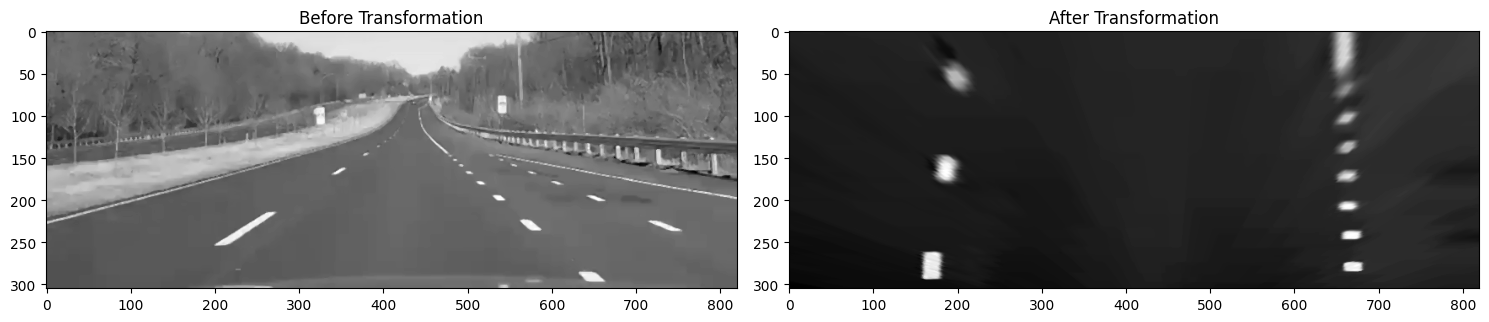

In [67]:
plot_images(smoothed_img, transformed_img, "Before Transformation", "After Transformation")

## Histogram

In [12]:
def histogram_equalization(img):
    # Load image using io.imread()
#     img = io.imread(image_path)

    # Compute histogram
    hist, bins = np.histogram(img.flatten(), bins=256)

    # Compute cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = (cdf * hist.max()) / cdf.max()

    # Perform histogram equalization
    equalized_img = np.interp(img.flatten(), bins[:-1], cdf_normalized).reshape(img.shape)

    # ** normalize image pixel values
    min_value = np.min(equalized_img)
    max_value = np.max(equalized_img)
    # print(equalized_img, min_value, max_value)
    image_normalized = (equalized_img - min_value) / (max_value - min_value)
    
    return image_normalized

In [13]:
equalized_img = histogram_equalization(s_image)

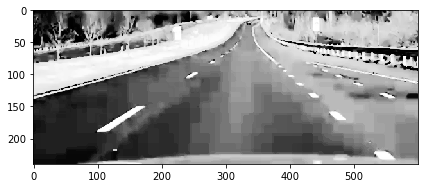

In [14]:
io.imshow(equalized_img, cmap='gray')
plt.show()

## Edge Detection (Thresholding | Canny)

In [68]:
def plot_hist(img, title=""):
    x = plt.hist(img.reshape(-1), bins=256, color='red')
    plt.title(title + " Histogram")
    plt.show()

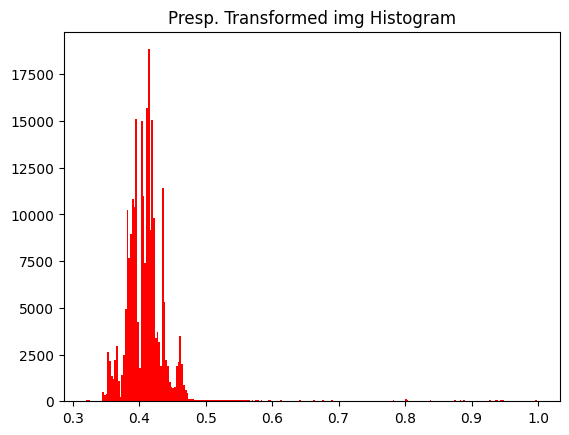

In [69]:
plot_hist(transformed_img, "Presp. Transformed img")

In [70]:
# Apply Canny edge detection with adjustable parameters
canny_edges_result = None
def apply_canny(img, sigma, low_threshold, high_threshold):
    global canny_edges_result
    canny_edges_result = canny(img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    
    # Display the edge image
    plt.figure(figsize=(6, 6))
    plt.imshow(canny_edges_result, cmap='gray')
    plt.title(f'Canny Edges (Sigma={sigma}, Low={low_threshold}, High={high_threshold})')
    plt.axis('off')
    plt.show()
    
    

In [15]:
def apply_filter(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)
    filtered_img = fftpack.ifft2(filtered_img_in_freq)
    return filtered_img

In [16]:
def canny_edge_detection(image, sigma=2.0, low_threshold=50, high_threshold=150):
    # Convert the image to grayscale
#     gray_image = rgb2gray(image)  # modified
    
    # Apply Gaussian smoothing to reduce noise
    smoothed_image = gaussian(image, sigma)
    
    # ** Add low pass filter
    f=np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
            ])
    
    smoothed_image = np.abs(apply_filter(smoothed_image, f))
    print(smoothed_image)
    # Compute gradients using Sobel filters
    gradient_x = np.gradient(smoothed_image, axis=1)
    gradient_y = np.gradient(smoothed_image, axis=0)

    # Compute gradient magnitude and direction
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)
    
    # Apply non-maximum suppression to thin the edges
    suppressed_image = np.zeros_like(gradient_magnitude)

    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            angle = gradient_direction[i, j]
            if (0 <= angle < np.pi/8) or (7*np.pi/8 <= angle <= np.pi):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            elif (np.pi/8 <= angle < 3*np.pi/8):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            elif (3*np.pi/8 <= angle < 5*np.pi/8):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            else:
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]
            if gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r:
                suppressed_image[i, j] = gradient_magnitude[i, j]
    
    suppressed_image = suppressed_image * 255  # modified
    
    # Apply hysteresis thresholding to detect edges
    edges = np.zeros_like(suppressed_image)
    strong_edges = suppressed_image > high_threshold
    edges[strong_edges] = 255
    
    weak_edges = (suppressed_image >= low_threshold) & (suppressed_image <= high_threshold)
    max_iter = 50 # modified
    while (np.sum(weak_edges) > 0 and max_iter > 0): # modified
        max_iter -= 1
        weak_edges_coords = np.argwhere(weak_edges)
        i, j = weak_edges_coords[0]
        edges[i, j] = 255
        weak_edges[i, j] = False
        neighbors = weak_edges[max(0, i-1):min(i+2, weak_edges.shape[0]), max(0, j-1):min(j+2, weak_edges.shape[1])]
        if np.sum(neighbors) > 0:
            weak_edges[np.where(neighbors)] = True

    return edges

In [71]:
# Define sliders for the parameters
sigma_slider = FloatSlider(min=1, max=5.0, step=0.2, value=1.1, description='Sigma:')
low_threshold_slider = FloatSlider(min=0.1, max=1.0, step=0.05, value=0.15, description='Low Threshold:')
high_threshold_slider = FloatSlider(min=0.1, max=1.0, step=0.05, value=0.2, description='High Threshold:')

# Create the interactive widget
interact(apply_canny, img=fixed(transformed_img), 
         sigma=sigma_slider, low_threshold=low_threshold_slider,
         high_threshold=high_threshold_slider)


interactive(children=(FloatSlider(value=1.1, description='Sigma:', max=5.0, min=1.0, step=0.2), FloatSlider(va…

<function __main__.apply_canny(img, sigma, low_threshold, high_threshold)>

In [72]:
binary_img = None
def gray_to_binary_test(img, threshold):
    """converts a gray scaled image to binary."""
    global binary_img
    binary_img = np.where(img > threshold, 1, 0)
    
    # Display image
    plt.figure(figsize=(6, 6))
    plt.imshow(binary_img, cmap='gray')
    plt.title(f'Binary Threshold = {threshold}')
    plt.axis('off')
    plt.show()

In [73]:
# Define sliders for the parameters
threshold_slider = FloatSlider(min=0, max=1, step=0.01, value=0.61, description='Threshold:')

# Create the interactive widget
interact(gray_to_binary_test, img=fixed(transformed_img), threshold=threshold_slider)


interactive(children=(FloatSlider(value=0.61, description='Threshold:', max=1.0, step=0.01), Output()), _dom_c…

<function __main__.gray_to_binary_test(img, threshold)>

Best Threshold is 0.5 for this frame

# Morphological operation

In [74]:
opened_img = None
def apply_erosion_test(img, element_size):
    """Applies opening morphological operation."""
    global opened_img
    
    element = morphology.rectangle(element_size, element_size+10)
    
    # Performing dilation and erosion separately
    dilated_img = morphology.dilation(img, element)
    
    # Display the opened image
    plt.figure(figsize=(6, 6))
    plt.imshow(dilated_img, cmap='gray')
    plt.title(f'Morphological Opening (Element Size: {element_size})')
    plt.show()

    opened_img = dilated_img



# Create a slider for the element size parameter
element_size_slider = IntSlider(min=1, max=50, step=1, value=1, description='Element Size')

# Create the interactive widget
interact(apply_erosion_test, img=fixed(binary_img), element_size=element_size_slider);    

interactive(children=(IntSlider(value=1, description='Element Size', max=50, min=1), Output()), _dom_classes=(…

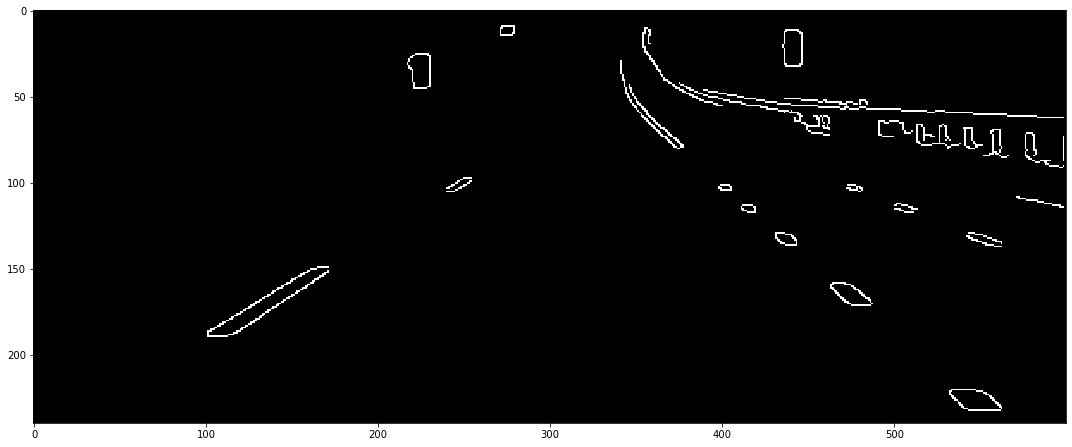

In [18]:
plt.figure(figsize=(15, 10))  # Define the figure size (width, height)
io.imshow(edged_image, cmap='gray')
plt.show()

## Prespective Transformation

In [35]:
#corner Points (needs to be put manualy)

def prespective_transformation(img):
    # frame = cv2.resize(img,(640,480), interpolation=cv2.INTER_NEAREST)
    frame = img
    tl= (250, 50) #Top Left
    bl=(0, 240)   #Bottom Left
    tr=(350, 50)  #Top Right
    br=(580,240)  #Bottom Right
    
    cv2.circle(frame, tl, 5 , (0, 0, 255),-1)
    cv2.circle(frame, bl, 5 , (0,0,255),-1)
    cv2.circle(frame, tr, 5 , (0,0,255),-1)
    cv2.circle(frame, br, 5 , (0,0,255),-1)

    pt1=np.float32([tl,bl,tr,br])                       #Source Points
    pt2=np.float32([[0,0],[0,480],[640,0],[640,480]])   #Destination Points

    #Perspective Transformation
    matrix= (cv2.getPerspectiveTransform(pt1,pt2)) 
    transformed_frame= cv2.warpPerspective(frame, matrix,(640,480))

    #Inverse Perspective Transformation
    matrix2= np.linalg.inv(matrix)
    inverted_transformed_frame= cv2.warpPerspective(transformed_frame,matrix2,(640,480))
    return transformed_frame, inverted_transformed_frame, frame



In [36]:
t_frame, it_frame, frame = prespective_transformation(edged_image)

In [ ]:
cv2.imshow("transformed frame",t_frame)
cv2.imshow("Frame", frame)
cv2.imshow("inverted tranformation",it_frame)
cv2.waitKey(0)

# Hough Transform

In [75]:
hough_ = Hough(5, 200)

In [76]:
r1, theta1, r2, theta2 = hough_.get_polar_coorindates(opened_img)
lane1_mask = hough_.get_mask(opened_img, r1, theta1)
lane2_mask = hough_.get_mask(opened_img, r2, theta2)
lanes_mask = np.maximum(lane1_mask, lane2_mask)
print(r1,r2)

648 0


# Inverse Perspective Transformation

In [77]:
def inv_perspective_transform(inv_frame, t_matrix, W, H):
    """Applies Inverse Perspective Transformation on a transformed frame."""
    inv_t_matrix= np.linalg.inv(t_matrix)
    frame = cv2.warpPerspective(inv_frame, inv_t_matrix, (W, H))
    return frame

In [78]:
H, W, _ = lanes_mask.shape
inv_lanes_mask = inv_perspective_transform(lanes_mask, PT_matrix, W, H)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


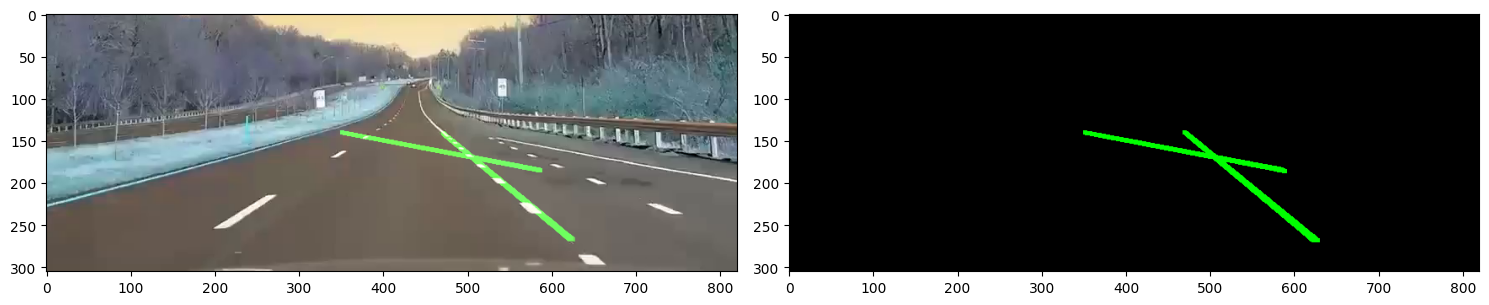

In [79]:
inv_lanes_mask[:, :, 1] = dilation(inv_lanes_mask[:, :, 1], square(5))
        
cropped_img[:, :, 1] = np.maximum(cropped_img[:, :, 1], inv_lanes_mask[:, :, 1])
plot_images(cropped_img, inv_lanes_mask, "", "")

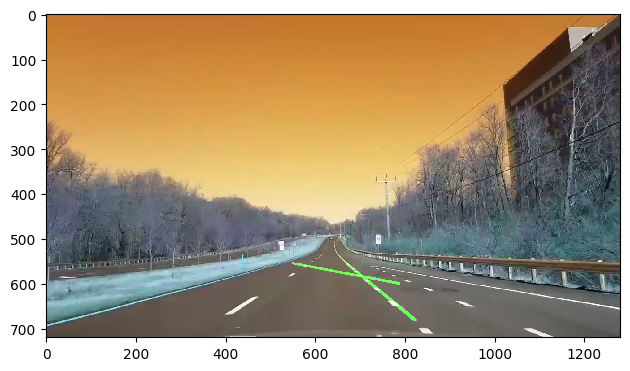

In [80]:
# original image
frame[y1:y2, x1:x2] = cropped_img
io.imshow(frame)

# PipeLine

In [81]:
def calc_distance_between_lines(r1, theta1, r2, theta2):
    """calculates distance between two lines given their r and theta in 
        polar coordinates.
    """
    dist = np.abs(r1 - r2 * np.cos(theta1 - theta2))
    return dist
    

In [82]:
distances1 = []
distances2 = []
approved1 = []
approved2 = []
def pipeline(video_path):
    video = cv2.VideoCapture('images/LaneVideo.mp4')
    i = 0

    prev_xleft = [0]
    prev_xright = [0]
    prev_yleft = [0]
    prev_yright = [0]

    past_r1, past_r2, past_theta1, past_theta2 = 0, 0, 0, 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        
        # crop image using the following dimensions 
        cropped_img = ROI(frame, x1, x2, y1, y2)
        if(i % 1 == 0):
            # smooth image
            # smoothed_img = smooth(cropped_img)
            smoothed_img = rgb2gray(cropped_img)
            
            # apply Prespective transformation
            transformed_img, PT_matrix, pts_source = perspective_transformation(smoothed_img)
            
            # convert to binary
            threshold = 0.65
            binary_img = gray_to_binary(transformed_img, threshold)
            
            # add morphological opeations if needed
            element_size = 25
            element = morphology.rectangle(element_size, element_size+10)
            morph_img = morphology.dilation(binary_img, element)
     
            # Applying sliding window to get the curvature
            x_left, x_right, left_y, right_y, msk = sliding_window(morph_img, morph_img.shape[0], 40, 100, binary_img)

            # Check if the windows of the frame contains the lane
            if ((len(x_left) == 0) or (len(x_right) == 0)):
                x_left = prev_xleft
                x_right = prev_xright
                left_y = prev_yleft
                right_y = prev_yright
            else:
                prev_xleft = x_left
                prev_xright = x_right
                prev_yleft = left_y
                prev_yright = right_y

            # Fitting the quadratic curve
            L_curve, R_curve = curve_fitting(x_left, x_right, left_y, right_y)

            # Get the radius of curvature
            dir, L_curve_val, R_curve_val = get_Curvature(L_curve, R_curve, 150)

            print(f'Direction = {dir}')
            print(f'Left Curve = {L_curve_val}')
            print(f'Right Curve = {R_curve_val}')
            
            # apply hough transfomration
            hough_ = Hough(5, 500)
            r1, theta1, r2, theta2 = hough_.get_polar_coorindates(morph_img)


            lane1_mask = hough_.get_mask(morph_img, r1, theta1)
            lane2_mask = hough_.get_mask(morph_img, r2, theta2)
            lanes_mask = np.maximum(lane1_mask, lane2_mask)
            # apply inverse tranformation
            H, W, _ = lanes_mask.shape
            inv_lanes_mask = inv_perspective_transform(lanes_mask, PT_matrix, W, H)
        
            # add mask to the original frame
            inv_lanes_mask[:, :, 1] = dilation(inv_lanes_mask[:, :, 1], square(5)) # dilation   
        

        cropped_img[:, :, 1] = np.maximum(cropped_img[:, :, 1], inv_lanes_mask[:, :, 1])
        frame[y1:y2, x1:x2] = cropped_img

        i += 1
        
        # Display the frame
        cv2.imshow('Video Player', frame)
        cv2.imshow('sliding', msk.astype(float))
        #cv2.imshow("PT", binary_img.astype(float))
        # Check for user input to exit (press 'q')
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Release resources
    video.release()
    cv2.destroyAllWindows()

In [91]:
%time pipeline('images/LaneVideo.mp4')

Direction = left
Left Curve = 2.9452065455414393
Right Curve = 4514066.167018237
Direction = right
Left Curve = 21.494287281157334
Right Curve = 199939.17563593114
Direction = right
Left Curve = 19.157631128870563
Right Curve = 245063.37747968605
Direction = left
Left Curve = 1.9414823379553
Right Curve = 950635.7398377437
Direction = right
Left Curve = 40.568948662837094
Right Curve = 2948636.663102003
Direction = right
Left Curve = 42.44813861002199
Right Curve = 783454.9629176947
Direction = left
Left Curve = 1.8104423640720035
Right Curve = 88628225.28142978
Direction = right
Left Curve = 3.0948351718990117
Right Curve = 14016318.923289027
Direction = left
Left Curve = 736.0676700819457
Right Curve = 65945492.43844685
Direction = left
Left Curve = 208.56553379931708
Right Curve = 81359913.61549732
Direction = left
Left Curve = 95.23744366456279
Right Curve = 7056401.644405865
Direction = left
Left Curve = 76.66960996914412
Right Curve = 38254523.73553283
Direction = right
Left Curv

C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = left
Left Curve = 24.658927755402328
Right Curve = 54.93038939602672
Direction = left
Left Curve = 17.324327169564498
Right Curve = 52.89802054685798


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = left
Left Curve = 18.17223532129579
Right Curve = 51.86548125801171
Direction = left
Left Curve = 16.273199721113162
Right Curve = 53.320876293178465


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = left
Left Curve = 16.012478615023063
Right Curve = 48.17790625448565
Direction = left
Left Curve = 16.88610013094222
Right Curve = 47.73955189325331


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = left
Left Curve = 15.88949639328195
Right Curve = 41.627568421323026
Direction = left
Left Curve = 19.221180070607215
Right Curve = 44.779440187644546


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = left
Left Curve = 22.091780481632092
Right Curve = 45.14741023371975
Direction = left
Left Curve = 17.47555152776556
Right Curve = 49.77861077474821


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = left
Left Curve = 18.972086970566377
Right Curve = 42.80174821994769
Direction = left
Left Curve = 26.073337684512406
Right Curve = 45.52040833652215


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = left
Left Curve = 49.4860121306569
Right Curve = 39.64311567543537
Direction = right
Left Curve = 104.99746870565197
Right Curve = 788.5999808047288


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 102.90593437056955
Right Curve = 792.6241494263135
Direction = right
Left Curve = 101.83195375567638
Right Curve = 793.7921220914336


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 101.396851734643
Right Curve = 798.1594375426563
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.ar

Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248
Direction = right
Left Curve = 99.77866584523254
Right Curve = 801.1454505196248


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 126.71481338019024
Right Curve = 23.68630241204554
Direction = right
Left Curve = 138.10523511486855
Right Curve = 24.026049043244512


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 94.89136886040033
Right Curve = 34.78967374890199
Direction = right
Left Curve = 57.80512349909319
Right Curve = 55.07628512835162


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 68.14547762788946
Right Curve = 55.07169487030605
Direction = right
Left Curve = 31327.618570085637
Right Curve = 738499.4697227097
Direction = right
Left Curve = 265503.053292673
Right Curve = 935789.3904504962
Direction = right
Left Curve = 49.478538065618174
Right Curve = 19.749356412746913


C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:4: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y), 2)
C:\Users\user\AppData\Local\Temp\ipykernel_14648\3970954785.py:5: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y), 2)


Direction = right
Left Curve = 15185010.796721552
Right Curve = 17658.914665121185
Direction = right
Left Curve = 13194.389609739232
Right Curve = 2493.1271725289066
Direction = right
Left Curve = 29566.31479868342
Right Curve = 545.4872569979927
Direction = right
Left Curve = 357.95051774900594
Right Curve = 31.834824893958473
Direction = right
Left Curve = 2076.611335538803
Right Curve = 793.4446447276354
Direction = right
Left Curve = 169.09506752928962
Right Curve = 1904.6204939462773
Direction = right
Left Curve = 4.395571560133296
Right Curve = 1405.6466983193866
Direction = right
Left Curve = 10.659986743426359
Right Curve = 512.7860281017894
Direction = right
Left Curve = 67.45456169585455
Right Curve = 47.23103170043471
Direction = left
Left Curve = 338.9096295360739
Right Curve = 148.62130728116927
Direction = left
Left Curve = 2765.400441472862
Right Curve = 145.34928803725583
Direction = right
Left Curve = 578.3974611474173
Right Curve = 34.870419605402425
Direction = right

<BarContainer object of 0 artists>

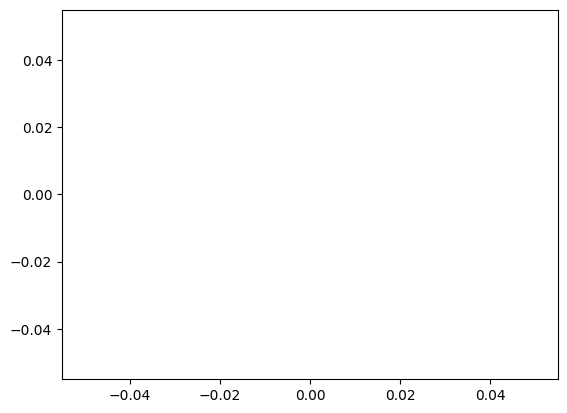

In [84]:
plt.bar(range(len(distances1)), distances1)
plt.bar(range(len(distances1)), approved1)


<BarContainer object of 0 artists>

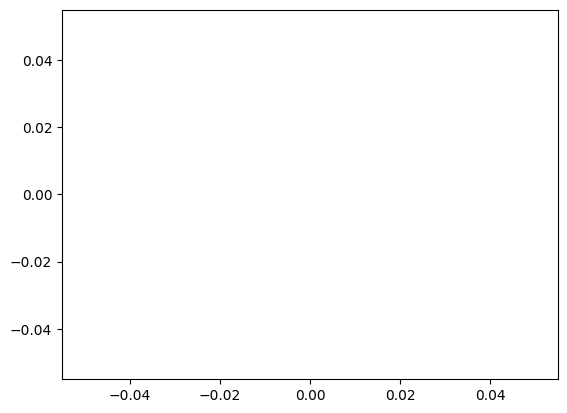

In [85]:
plt.bar(range(len(distances2)), distances2)
plt.bar(range(len(distances2)), approved2)

# Get the Lanes x-coordinates

In [86]:
def Get_lanes_bases(img):

    # Get the Histogram of the bottom half of the frame captured
    half_frame = img.shape[0] //4

    crop_half_frame = img[half_frame:,:]
    axis_Histogram = np.sum(crop_half_frame,axis = 0)

    # Get where is the max values located on the x-axis
    left_lane = np.argmax(axis_Histogram[:img.shape[1]//2])
    right_lane = (img.shape[1]//2) + np.argmax(axis_Histogram[img.shape[1]//2:]) 

    return left_lane, right_lane


# Sliding window

In [87]:
def sliding_window(img, imgHeight, window_height, window_width, original_img):

    left_lane, right_lane = Get_lanes_bases(img)
    msk = original_img.copy()
    # Arrays to hold the lane index
    x_left = []
    x_right = []

    left_y = []
    right_y = []
    
    # Creating the window on the lanes bases
    num_of_windows = imgHeight//window_height
    
    # Move the window on the lane
    for i in range(num_of_windows):
    
        left_lane_win = img[imgHeight -(i+1)*window_height:imgHeight - i*window_height, int(left_lane) - window_width//2:int(left_lane) + window_width//2]
        right_lane_win = img[imgHeight -(i+1)*window_height:imgHeight - i*window_height, int(right_lane) - window_width//2:int(right_lane) + window_width//2]

        cv2.rectangle(msk, (int(left_lane) - window_width//2,imgHeight -(i+1)*window_height), (int(left_lane) + window_width//2,imgHeight - i*window_height), (255,255,255), 2)
        cv2.rectangle(msk, (int(right_lane) - window_width//2,imgHeight -(i+1)*window_height), (int(right_lane) + window_width//2,imgHeight - i*window_height), (255,255,255), 2)
        # get the white pixels in the left and right window
        left_non_zero = np.argwhere(left_lane_win > 0)
        right_non_zero = np.argwhere(right_lane_win > 0)

        # Check if the window has no lane pixels
        if not ((left_non_zero.any() > 0) and (right_non_zero.any() > 0)):
            continue

        # add the index to the lane arrays
        left_new_index = left_non_zero[:,1] + max(0,(left_lane - window_width//2))
        right_new_index = right_non_zero[:,1] + max(0,(right_lane - window_width//2))

        # Lanes Y index
        left_y.append(imgHeight - i*window_height)
        right_y.append(imgHeight - i*window_height)

        # update the window base
        left_lane = np.mean(left_new_index)
        right_lane = np.mean(right_new_index)

        x_left.append(left_lane)
        x_right.append(right_lane)

    
    return x_left, x_right, left_y, right_y , msk


In [88]:
def curve_fitting(x_left, x_right, left_y, right_y):
    
    # Curve fitting(2nd degree poynomial) for the points from the window
    left_curve = np.polyfit(x_left, np.array(left_y), 2)
    right_curve = np.polyfit(x_right, np.array(right_y), 2)

    return left_curve, right_curve


# Get Curvature

In [89]:
def get_Curvature(left_curve, right_curve, img_h, y_meter_per_pixel= 15/350, x_meter_per_pixel = 3.7/500, y_value = 150 ):

    # polynomial fitting = Ax^2 + Bx + C
    A_left, B_left, C_left = left_curve
    A_right, B_right, C_right = right_curve

    # If A = -ve , then the direction of curvature is at the left & vice-versa
    if (A_left and A_right) > 0:
        direction = 'right'
    elif (A_left and A_right) < 0:
        direction = 'left'
    else:
        direction = 'straight'

    # Radius of curvature = ((1 + (2Ax + B)**2)**(3/2)) / |2A|
    left_curve = []
    right_curve = []

    # Getting the radius of curvature of set of points on the curves 

    # Map unit of coefficients and locaiton from pixel to meter
    A_l = x_meter_per_pixel / (y_meter_per_pixel**2) * A_left
    B_l = x_meter_per_pixel / y_meter_per_pixel * B_left

    A_r = x_meter_per_pixel / (y_meter_per_pixel**2) * A_right
    B_r = x_meter_per_pixel / y_meter_per_pixel * B_right
   

    # Get the mean values 
    L_curvature = ((1 + (2 * A_l * y_value * y_meter_per_pixel + B_l)**2)**1.5) / np.abs(2 * A_l)
    R_curvature = ((1 + (2 * A_r * y_value * y_meter_per_pixel + B_r)**2)**1.5) / np.abs(2 * A_r)

    return direction, L_curvature, R_curvature